In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from utils.conn_data import load_pickle
from signals.TSM import TSM
from portfolio_tools.Diagnostics import Diagnostics

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1.5

warnings.filterwarnings("ignore")

In [75]:
inputs_path = os.path.join(os.getcwd(), 'data', 'inputs')
instruments = [

    'SPY'

]

## Strategy Inputs

In [76]:
name = "training_etfstsm_moskowitz"

etfstsm_moskowitz = load_pickle(os.path.join(inputs_path, name, f"{name}.pickle"))

etfstsm_moskowitz.keys()

dict_keys(['bars'])

In [77]:
etfstsm_moskowitz["bars"].keys()

dict_keys(['SPY', 'IWM', 'EEM', 'TLT', 'USO', 'GLD', 'XLF', 'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY', 'XLP', 'XLE', 'VIX', 'AGG', 'DBC', 'HYG', 'LQD', 'UUP'])

In [78]:
bars = []
for instrument in instruments:
    bars.append(etfstsm_moskowitz["bars"][instrument].rename(columns={"Close": instrument}))
bars_df = pd.concat(bars, axis=1)

In [79]:
returns_info = []
for instrument in instruments:
    tmp_return = np.log(etfstsm_moskowitz["bars"][instrument][["Close"]]).diff().dropna()
    returns_info.append(tmp_return.rename(columns={'Close': f"{instrument}"}))

returns_info = pd.concat(returns_info, axis=1)

In [80]:
returns_info.head()

,SPY
date,
2007-04-12,0.004434
2007-04-13,0.004552
2007-04-16,0.009451
2007-04-17,0.002655
2007-04-18,0.001223


## Moskowitz Trend Signal

In [96]:
trend_signal = TSM()
window = 252

signals = []
for instrument in instruments:
    signal = trend_signal.Moskowitz(returns=returns_info[[instrument]], window=window)
    signals.append(signal)
signals_df = pd.concat(signals, axis=1)

forecasts = []
for instrument in instruments:
    forecast = np.where(signals_df[instrument] > 0, 1, -1)

    forecasts.append(pd.DataFrame(forecast, index=signals_df.index, columns=[instrument]))
forecasts_df = pd.concat(forecasts, axis=1)

In [97]:
signals_df.tail()

,SPY
date,
2023-11-16,0.000517
2023-11-17,0.000399
2023-11-20,0.000432
2023-11-21,0.000428
2023-11-22,0.000516


In [98]:
forecasts_df.tail()

,SPY
date,
2023-11-16,1
2023-11-17,1
2023-11-20,1
2023-11-21,1
2023-11-22,1


Text(0.5, 1.0, 'Trend')

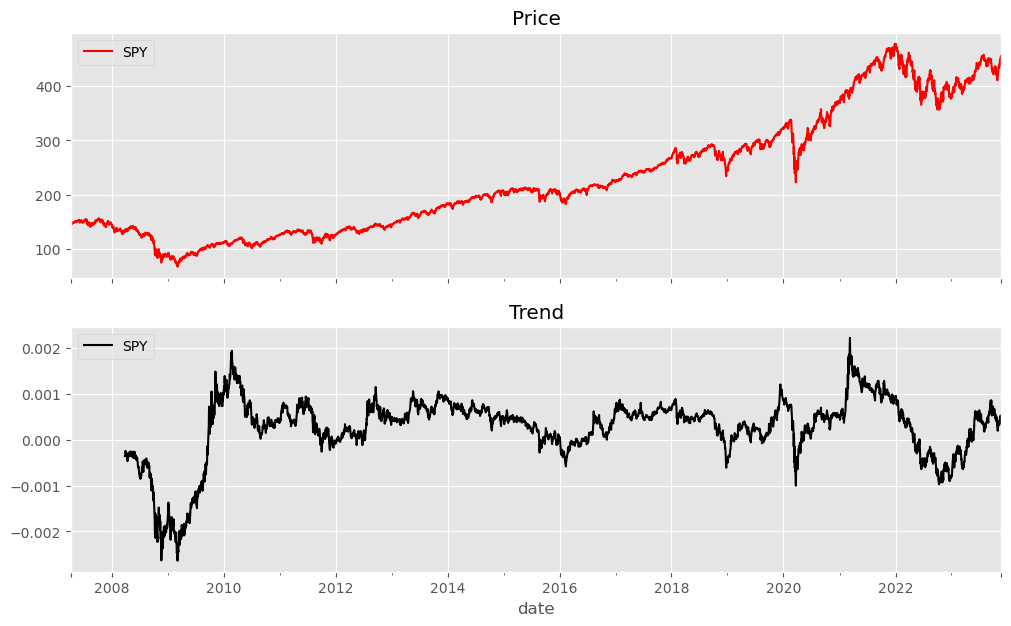

In [99]:
tickers = "SPY"
start_date = "2000-01-01"

# multiple plot price and signal
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

bars_df[tickers].loc[start_date:].plot(ax=ax[0], color="red")

ax[0].legend(loc="upper left")
ax[0].set_title("Price")

signals_df[tickers].loc[start_date:].plot(ax=ax[1], color="black")

ax[1].legend(loc="upper left")
ax[1].set_title("Trend")

In [104]:
vol_target = 0.15
vol_window = 90
data_freq = 255
rets_df = returns_info.copy()
vols_df = returns_info.rolling(window=vol_window).std() * np.sqrt(data_freq)

# compute vol scaling
vol_scale = vol_target / vols_df

# compute portfolio returns
portfolio_returns = (forecasts_df.shift(+1) * rets_df).fillna(0)

# compute scaled portfolio returns
scaled_portfolio_returns = vol_scale.shift(+1) * portfolio_returns

<Axes: title={'center': 'Scaled Portfolio Returns'}, xlabel='date'>

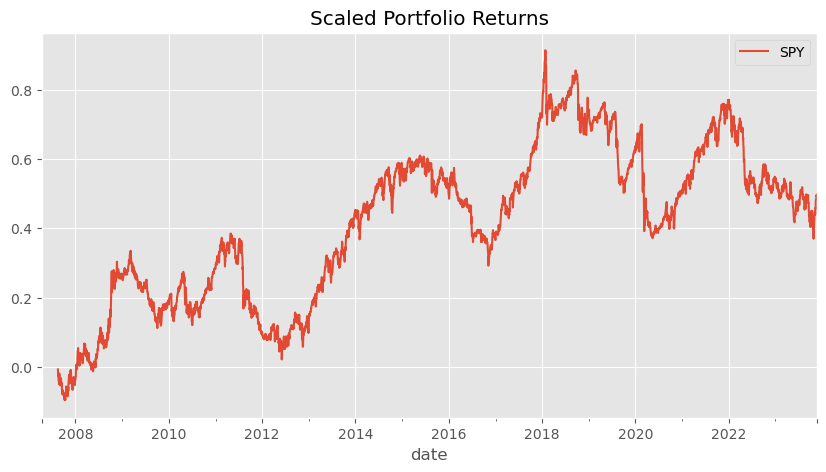

In [105]:
scaled_portfolio_returns.cumsum().plot(figsize=(10, 5), title="Scaled Portfolio Returns")

In [106]:
# scaled_portfolio_returns.drop(["VIX"], axis=1).cumsum().plot(figsize=(10, 5), title="Scaled Portfolio Returns")

In [107]:
# ret1 = scaled_portfolio_returns.mean(axis=1).dropna()
# ret2 = scaled_portfolio_returns.drop(["VIX"], axis=1).mean(axis=1).dropna()

# diag = Diagnostics()

# metrics1 = pd.DataFrame([diag.compute_summary_statistics(portfolio_returns=ret1)])
# metrics2 = pd.DataFrame([diag.compute_summary_statistics(portfolio_returns=ret2)])

# metrics = pd.concat([metrics1, metrics2], axis=0)
# metrics.index = ["All ETFs", "All ETFs Ex VIX"]

# metrics